# Google colab

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

### Sacha 

In [0]:
path_collab = "DTU/DL/DeepLearningProject"
import os
os.path.isfile("drive/"+path_collab)
!mkdir drive
!google-drive-ocamlfuse drive
!ls drive/"DTU/DL/DeepLearningProject"

Final.ipynb  glove.6B.50d.txt  main.ipynb  Note.odt


### Damian

In [0]:
path_collab = "DeepLearningProject"
import os
os.path.isfile("drive/"+path_collab)
!mkdir drive
!google-drive-ocamlfuse drive
!ls drive/"DeepLearningProject"

mkdir: cannot create directory ‘drive’: File exists
ls: cannot access 'drive/DeepLearningProject': No such file or directory


### Path

In [0]:
path_glove_50 = "drive/"+path_collab +'/glove.6B.50d.txt'

NameError: ignored

# Import

In [0]:
!pip install torch
!pip install torchtext
!pip install pytorch-nlp

    100% |████████████████████████████████| 591.8MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62764000 @  0x7f83b47322a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 71kB 6.2MB/s 
    100% |████████████████████████████████| 92kB 7.3MB/s 


In [0]:
#imports
import torch
import torchtext
from torchtext import data
from torchtext import datasets
from torchnlp.datasets import snli_dataset
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import softmax, relu

from torchtext import vocab
from torchtext.vocab import Vectors, GloVe

import numpy as np
import matplotlib.pyplot as plt

# Preprocessing

In [0]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    return x.cuda() if use_cuda else x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    return x.cpu().data.numpy() if use_cuda else x.data.numpy()

In [0]:
device = torch.device('cuda:0')

In [0]:
inputs = data.Field(sequential=True)
answers = data.Field(sequential=False, unk_token=None)

In [0]:
train, dev, test = datasets.SNLI.splits(inputs, answers)

downloading snli_1.0.zip


snli_1.0.zip: 100%|██████████| 94.6M/94.6M [00:07<00:00, 12.2MB/s]


extracting


In [0]:
inputs.build_vocab(train, dev, test, vectors='glove.840B.300d')

.vector_cache/glove.840B.300d.zip: 2.18GB [01:47, 20.3MB/s]                            
100%|█████████▉| 2196015/2196017 [05:19<00:00, 7529.14it/s]

In [0]:
answers.build_vocab(train)

In [0]:
train_iter, dev_iter, test_iter = data.BucketIterator.splits(
            (train, dev, test), batch_size=128, device=device)

In [0]:
print('train_set.fields:', list(train.fields.keys()))
print('test_set.fields:', list(test.fields.keys()))
print()
print('size of training set', len(train))
print('size of test set', len(test))
print()
print('content of one training sample:')
print(vars(train[4]))

train_set.fields: ['premise', 'hypothesis', 'label']
test_set.fields: ['premise', 'hypothesis', 'label']

size of training set 549367
size of test set 9824

content of one training sample:
{'premise': ['Children', 'smiling', 'and', 'waving', 'at', 'camera'], 'hypothesis': ['There', 'are', 'children', 'present'], 'label': 'entailment'}


# Bag of Words model (BoW)

In [0]:
num_embeddings = inputs.vocab.vectors.size()[0]
embedding_dim = inputs.vocab.vectors.size()[1]

class BoWNet(nn.Module):

    def __init__(self):
        super(BoWNet, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        
        self.embed.weight.data.copy_(inputs.vocab.vectors)
        
        self.lin = nn.Linear(600, 600)
        
        self.out_layer = nn.Linear(600, 3)
        
        self.tanh = nn.Tanh()
        
    def forward(self, batch):
        
        prem_embed = self.embed(batch.premise)
        hyp_embed = self.embed(batch.hypothesis)
        
        #shape = [44, 256, 50] === [max size of sentence, batch_size, glove_size]
        
        sum_prem = torch.sum(prem_embed, dim=0)
        sum_hyp = torch.sum(hyp_embed, dim=0)
        
        concat = torch.cat([sum_prem, sum_hyp], dim=1)
        
        #3 layers of 600d with tanh activation
        x = self.lin(concat)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        
        return softmax(self.out_layer(x), dim=1)

# LSTM RNN model

In [0]:
num_embeddings = inputs.vocab.vectors.size()[0]
embedding_dim = inputs.vocab.vectors.size()[1]

class LSTMNet(nn.Module):

    def __init__(self):
        super(LSTMNet, self).__init__()
        
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        
        self.embed.weight.data.copy_(inputs.vocab.vectors)
        
        self.rnn_prem = nn.LSTM(hidden_size = 100, input_size = embedding_dim)
        self.rnn_hyp = nn.LSTM(hidden_size = 100, input_size = embedding_dim)
        
        self.lin = nn.Linear(200, 200)
        self.out_layer = nn.Linear(200, 3)
        
        self.tanh = nn.Tanh()
        
    def forward(self, batch):
        prem_embed = self.embed(batch.premise)
        hyp_embed = self.embed(batch.hypothesis)
        
        #batch_size = batch.premise.size()[1]
        #state_shape = 1, batch_size, 100
        #h0 = c0 =  inputs.new_zeros(state_shape)
        outputs, (htp, ct) = self.rnn_prem(prem_embed)
        outputs, (hth, ct) = self.rnn_hyp(hyp_embed)
        
        concat = torch.cat([htp[-1], hth[-1]], dim=1)
        
        #3 layers of 600d with tanh activation
        x = self.lin(concat)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        x = self.lin(x)
        x = self.tanh(x)
        
        return softmax(self.out_layer(x), dim=1)

# Attention model

# Training

In [0]:
import math
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

In [0]:
# define loss function, optimizer, and accuracy metric
# note, you might want to think about the model first
net = BoWNet()
l_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=l_rate, weight_decay=1e-7)

def accuracy(ys, ts):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = torch.eq(torch.max(ys, 1)[1], ts)
    # averaging the one-hot encoded vector
    return torch.mean(correct_prediction.float())
print(net)

BoWNet(
  (embed): Embedding(64280, 300)
  (lin): Linear(in_features=600, out_features=600, bias=True)
  (out_layer): Linear(in_features=600, out_features=3, bias=True)
  (tanh): Tanh()
)


In [0]:
 if use_cuda:
    net.cuda()
    pass
epochs = 10

max_iter = 9000
pr_every = 300
eval_every = 600
train_loss, train_accs = [], []
plt_tr, plt_ev = [], []

step = 0

for epoch in range(epochs):
  train_iter.init_epoch()
  
  for i, batch in enumerate(train_iter):
    net.train()
    
    output = net(batch)
    
    batch_loss = criterion(output, batch.label)
    
    train_loss.append(get_numpy(batch_loss))
    train_accs.append(get_numpy(accuracy(output, batch.label)))
    plt_tr.append((step, get_numpy(accuracy(output, batch.label))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    step+=1
    
    
    if i % eval_every == 0:
      net.eval(); dev_iter.init_epoch()
      
      eval_loss, eval_accs = [], []
      with torch.no_grad():
        for dev_batch_idx, dev_batch in enumerate(dev_iter):
          answer = net(dev_batch)
          dev_loss = criterion(answer, dev_batch.label)
          
          eval_loss.append(get_numpy(dev_loss))
          eval_accs.append(get_numpy(accuracy(answer, dev_batch.label)))
        plt_ev.append((step, np.mean(eval_accs)))
          
      print("Validation acc: {:.2f}".format(np.mean(eval_accs)))
      print()
    
        
    if i % pr_every == 0:   
      print("epoch: {}, step: {}, Train summary: loss: {:.2f}, acc: {:.2f}".format(epoch, step, np.mean(train_loss), np.mean(train_accs)))
      train_loss, train_accs = [], []

Validation acc: 0.33

epoch: 0, step: 1, Train summary: loss: 1.10, acc: 0.29
epoch: 0, step: 301, Train summary: loss: 1.00, acc: 0.52
Validation acc: 0.60

epoch: 0, step: 601, Train summary: loss: 0.94, acc: 0.59
epoch: 0, step: 901, Train summary: loss: 0.94, acc: 0.60
Validation acc: 0.62

epoch: 0, step: 1201, Train summary: loss: 0.92, acc: 0.61
epoch: 0, step: 1501, Train summary: loss: 0.92, acc: 0.62
Validation acc: 0.61

epoch: 0, step: 1801, Train summary: loss: 0.91, acc: 0.63
epoch: 0, step: 2101, Train summary: loss: 0.90, acc: 0.63
Validation acc: 0.65

epoch: 0, step: 2401, Train summary: loss: 0.90, acc: 0.63
epoch: 0, step: 2701, Train summary: loss: 0.89, acc: 0.65
Validation acc: 0.65

epoch: 0, step: 3001, Train summary: loss: 0.89, acc: 0.65
epoch: 0, step: 3301, Train summary: loss: 0.89, acc: 0.65
Validation acc: 0.66

epoch: 0, step: 3601, Train summary: loss: 0.88, acc: 0.65
epoch: 0, step: 3901, Train summary: loss: 0.88, acc: 0.66
Validation acc: 0.65

epoc

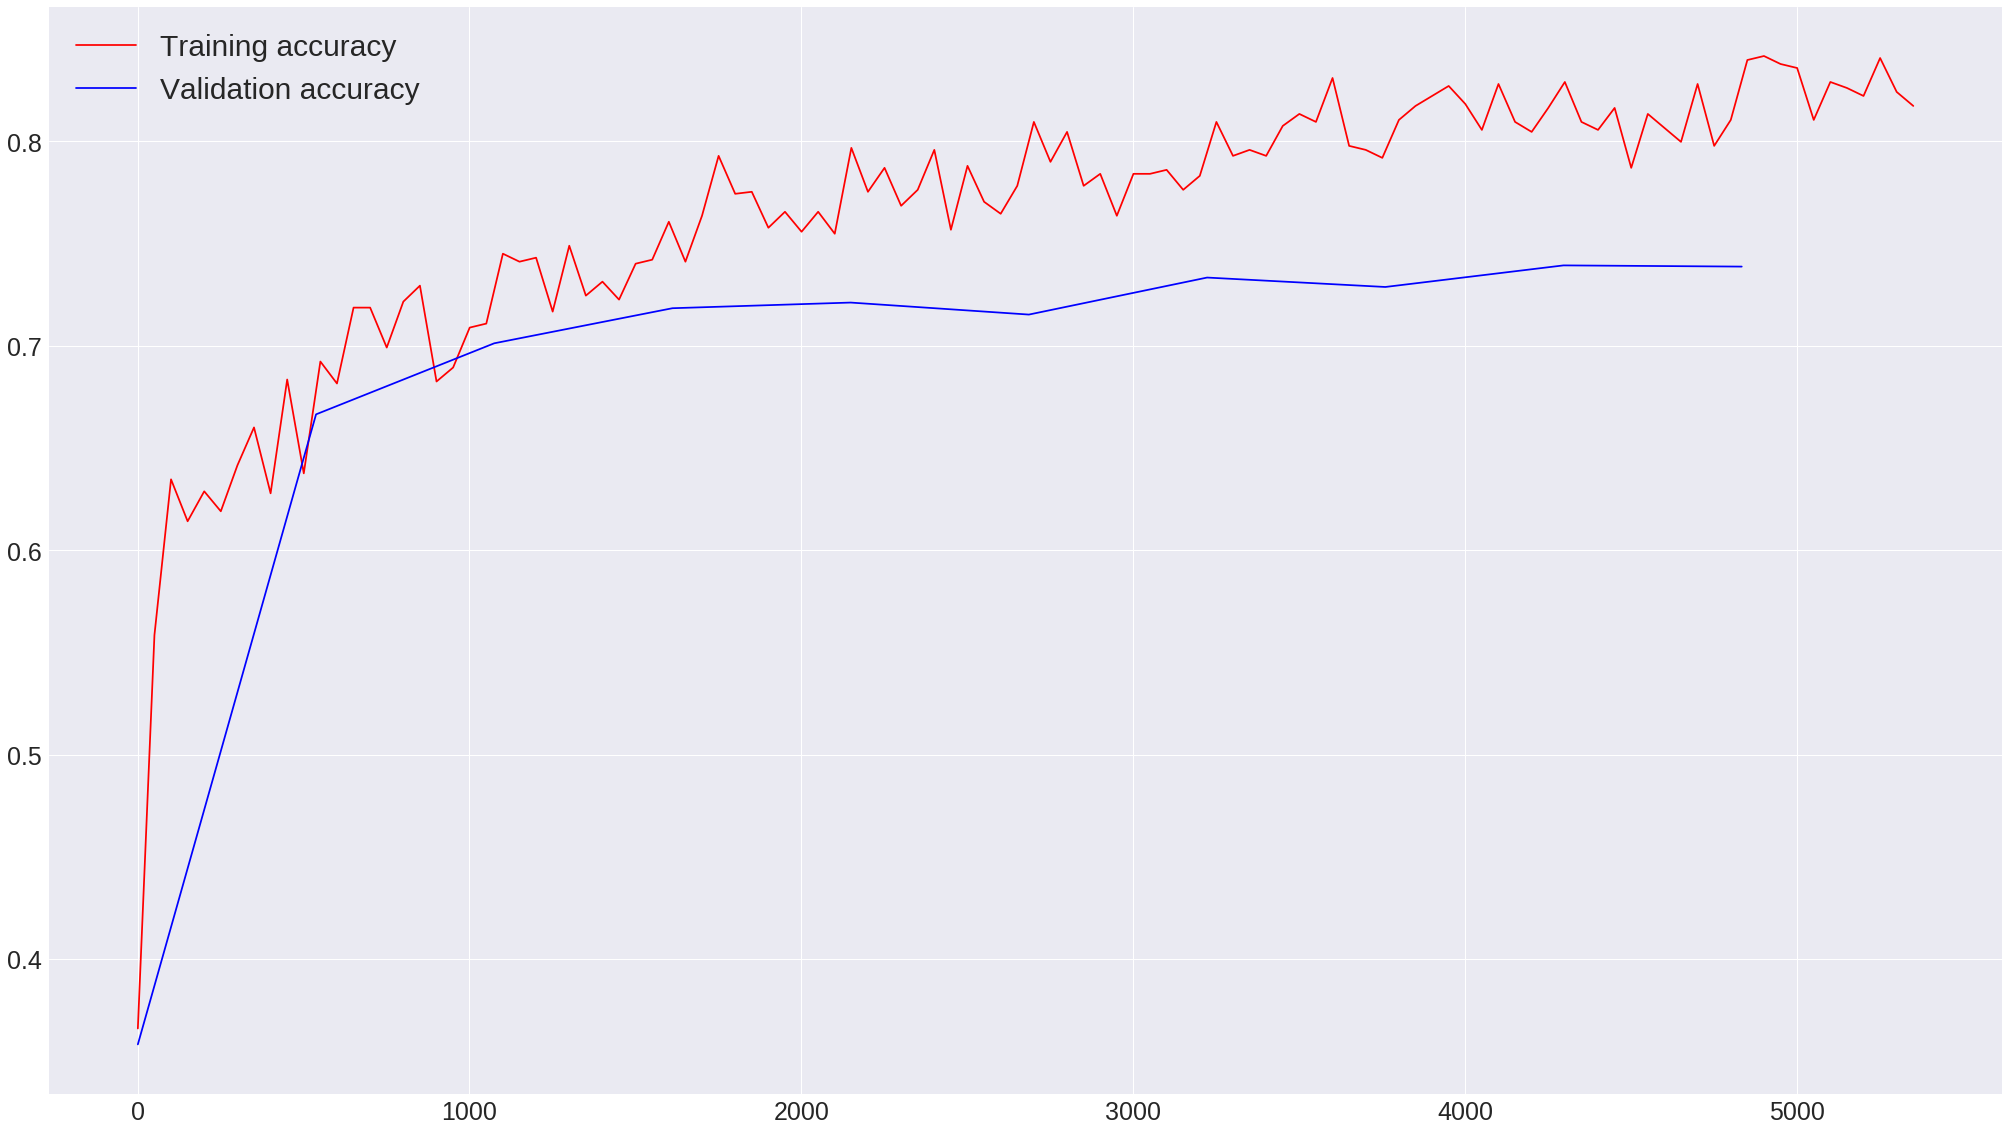

In [0]:
plt.rc('xtick', labelsize=25)
plt.rc('ytick', labelsize=25)
plt.figure(figsize=(35,20))
#plt.title('LSTM performance', fontsize=40)
plt.plot(np.array(plt_tr)[1::50,0], np.array(plt_tr)[1::50,1], label='Training accuracy', color='r')
plt.plot(np.array(plt_ev)[:,0], np.array(plt_ev)[:,1], label='Validation accuracy', color='b')
plt.legend(fontsize=30)
plt.show()

# GloVe visualizations for poster

In [0]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cosine

In [0]:
(vec('potato')+vec('king'))/2

array([ 0.220728 ,  0.029855 , -0.67967  , -0.0321425,  0.58165  ,
        0.36467  , -0.412735 , -0.11774  , -0.3455225, -0.528155 ,
       -0.212178 ,  0.81851  ,  0.7117055, -0.473521 ,  0.397265 ,
        0.47788  , -0.20695  ,  0.14352  , -0.2681565,  0.223095 ,
        0.1418565, -0.779175 ,  0.46067  , -0.07627  ,  0.273925 ,
       -1.26005  , -0.99194  , -0.36824  ,  0.49658  ,  0.24917  ,
        1.61505  , -0.121735 , -0.779255 ,  1.066725 ,  0.181995 ,
        0.430985 , -0.41738  ,  0.475285 ,  0.10005  ,  0.023265 ,
        0.13676  ,  0.79324  , -0.96845  , -0.173525 ,  0.559025 ,
        1.007505 , -0.3059   , -0.89957  , -0.242635 , -0.23091  ])

In [0]:
cercanas = find_nearest(vec('cat'), 10)
cercanas

['cat',
 'dog',
 'rabbit',
 'monkey',
 'rat',
 'cats',
 'snake',
 'dogs',
 'pet',
 'mouse',
 'bite',
 'shark',
 'puppy',
 'monster',
 'spider',
 'beast',
 'crocodile',
 'baby',
 'pig',
 'frog']

In [0]:

df = pd.DataFrame({
    'words': ['eat', 'eating', 'eaten', 'walk', 'walking', 'walked'],
})
df = pd.DataFrame({
    'words': ['king', 'prince', 'queen', 'emperor', 'son', 'uncle', 'potato', 'soup', 'tomato', 
              'mashed', 'cabbage', 'pumpkin', 'grandfather', 'bread', 'bean', 'family'],
})
df = pd.DataFrame({
    'words': ['king', 'queen', 'man', 'woman', 'actor', 'actress'],
})

x = []
for word in df['words']:
    x.append(vec(word))

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['words']]], axis = 1)

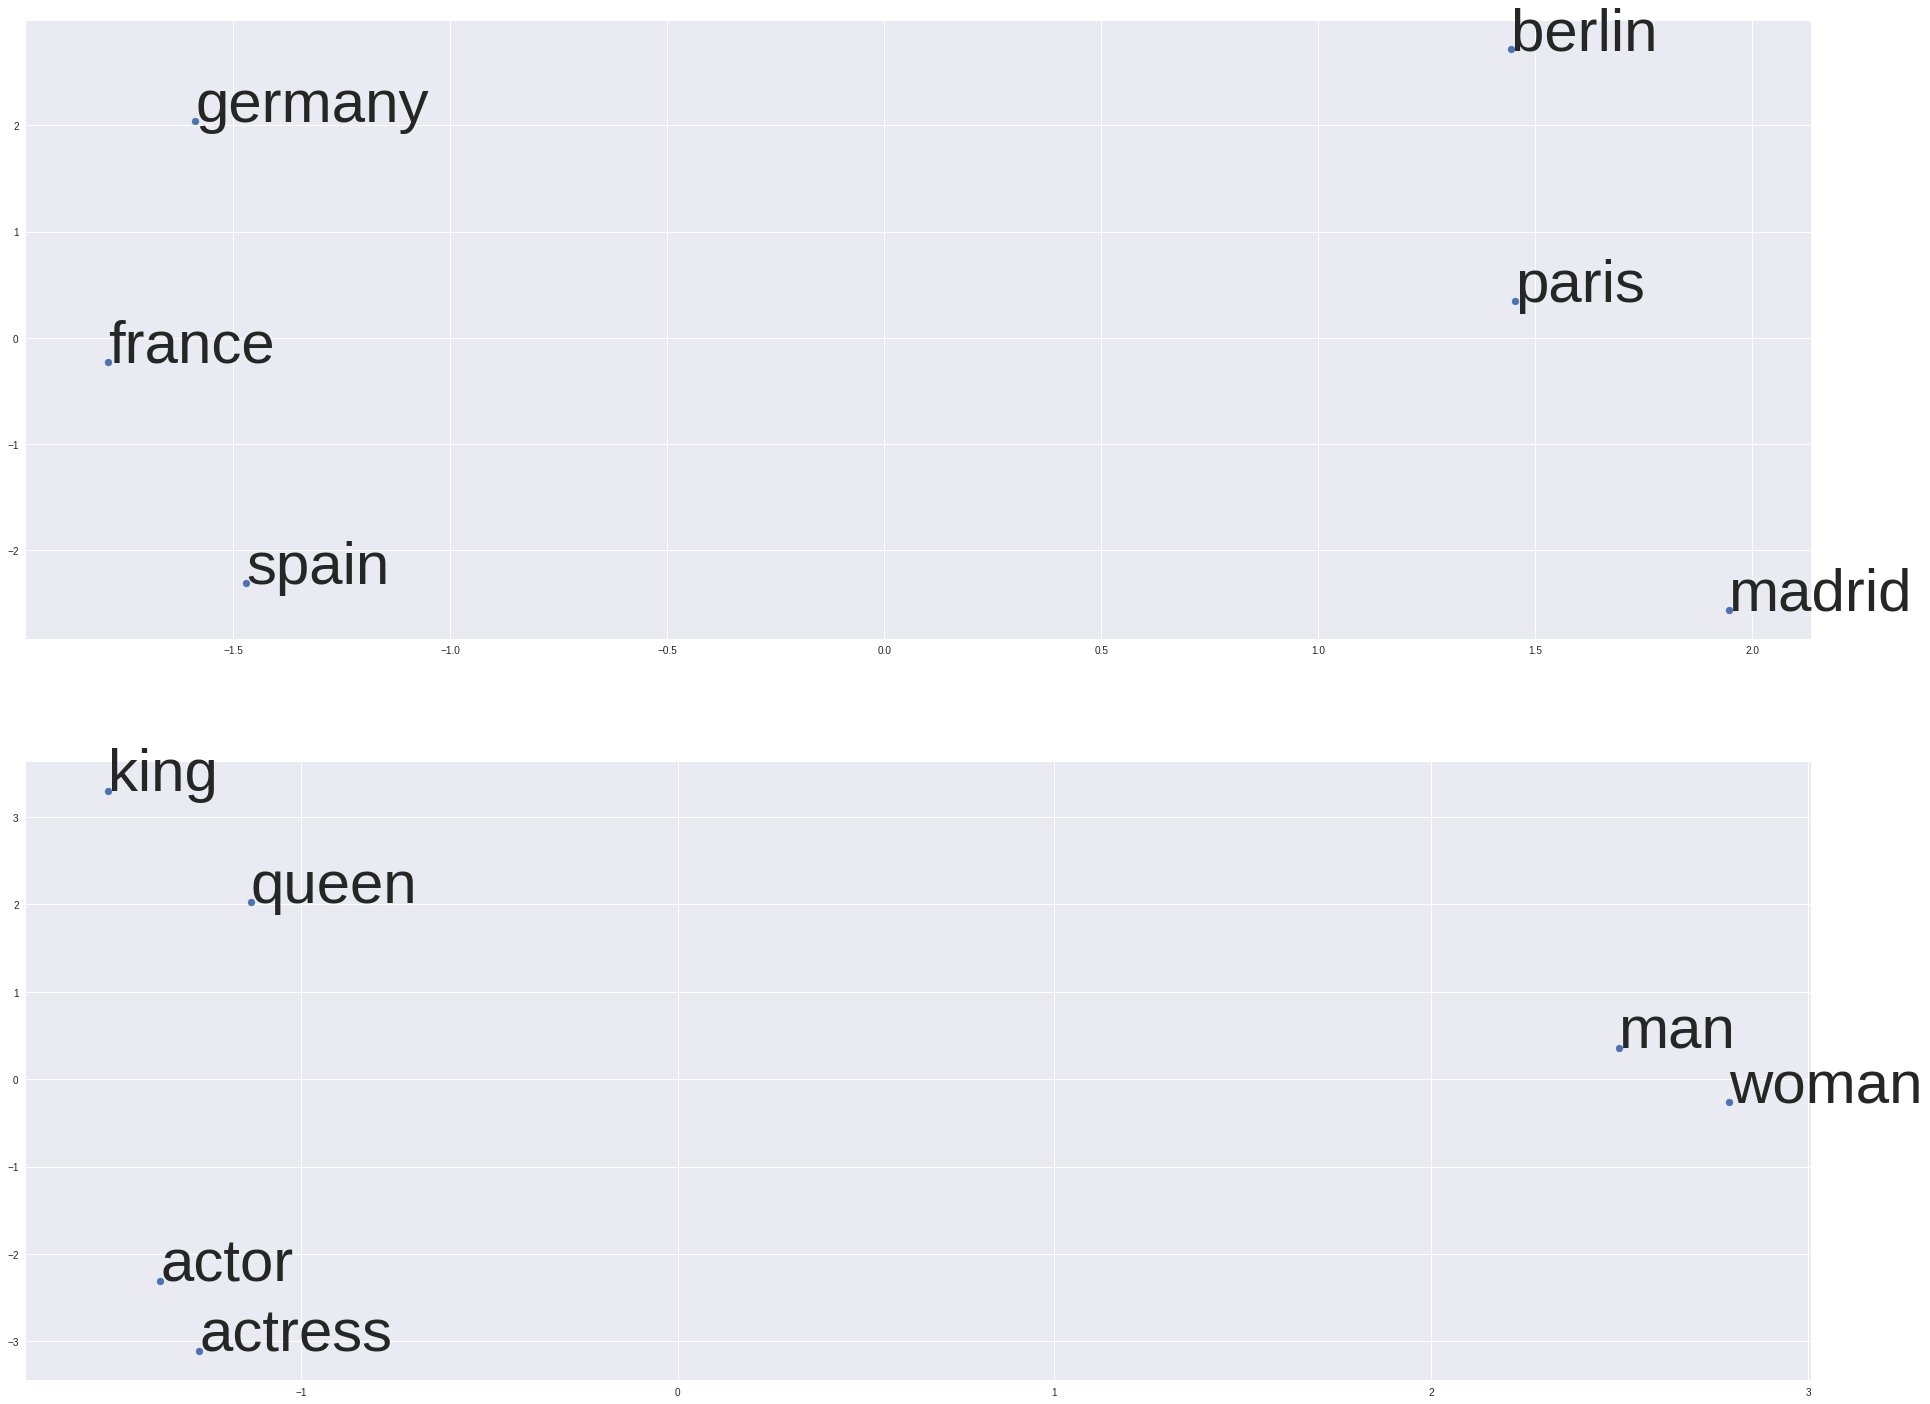

In [0]:
e1 = finalDf['principal component 1']
e2 = finalDf['principal component 2']
e3 = finalDf['words']

plt.figure(figsize=(32,25))
plt.subplot(211)
#plt.title('PCA of word embeddings', fontsize=60)
plt.scatter(z, y)

for i, txt in enumerate(n):
    plt.annotate(txt, (z[i], y[i]), fontsize=60)
    
plt.subplot(212)
plt.scatter(e2, e1)

for i, txt in enumerate(e3):
    plt.annotate(txt, (e2[i], e1[i]), fontsize=60)